In [1]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/Noza23/myovision/blob/main/notebooks/01_predict_performance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

In [ ]:
# Dependencies
!pip install 'myo_sam[all] @ git+https://github.com/Noza23/myovision-sam.git'
!pip install read-roi

# Predict

In [2]:
from myo_sam.inference.predictors.config import AmgConfig
from myo_sam.inference.pipeline import Pipeline

In [3]:
amg_config = AmgConfig.model_validate(
  {
    "points_per_side": 300,
    "points_per_batch": 100,
    "pred_iou_thresh": 0.85,
    "box_nms_thresh": 0.5,
    "stability_score_thresh": 0.95,
    "crop_n_layers": 0,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100
  }
)

In [4]:
# Setting-up models
pipeline = Pipeline()
pipeline._myosam_predictor.set_model("drive/MyDrive/myovision/checkpoint/myosam.pt", device="cuda:0")
pipeline._myosam_predictor.update_amg_config(amg_config)
pipeline._stardist_predictor.set_model("2D_versatile_fluo")

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [14]:
# Setting images
pipeline.set_myotube_image("../assets/myotube.tif", name="test_myotube_image")
pipeline.set_nuclei_image("../assets/nuclei.tif", name="test_nuclei_image")

In [15]:
# Run Prediction
results = pipeline.execute()

> Predicting Myotubes...
> Predicting patch 1/1...
> Predicting Nucleis...


# Inference

In [16]:
# General
print(results.information_metrics)
print(results.information_metrics.nuclei_clusters)

total_myotubes: 183
total_nucleis: 1823
total_myoblasts: 1307
total_nuclei_inside_myotubes: 516
total_fusion_index: 0.39
num_nuclei_clusters: 91
total_myotubes_area: 449525.0
total_nucleis_area: 302436.5
total_myoblasts_area: 227054.5
total_nucleis_inside_myotubes_area: 75382.0
num_clusters: 91


In [17]:
# Single Myotube
print(results.information_metrics.myotubes[0])

identifier: 0
measure_unit: 1.0
pred_iou: 0.99
stability: 0.97
is_on_edge: False
nuclei_ids: [74, 141, 427, 503, 564, 1116, 1266, 1274, 1532, 1585, 1671, 1675, 1801]
rgb_min: (0, 11, 0)
rgb_max: (0, 128, 0)
rgb_mean: (0, 60.65387918694532, 0)
rgb_median: (0, 62, 0)
rgb_mode: (0, 69, 0)
rgb_std: (0.0, 17.975194514885562, 0.0)
integrated_density_rgb: (0, 635592, 0)
area: 10193.0
convex_area: 12644.5
solidity: 0.81
aspect_ratio: 0.22
roundness: 3.5
perimeter: 628.82
max_feret_diameter: 280
min_feret_diameter: 71
circularity: 0.32
instance_fusion_index: 13
centroid: (870.109130859375, 281.94512939453125)


In [18]:
# Single Nuclei
print(results.information_metrics.nucleis[0])

identifier: 0
measure_unit: 1.0
myotube_ids: []
centroid: (1078.0, 840.0)
prob: None
area: 141.5
convex_area: 145.0
solidity: 0.98
aspect_ratio: 0.9
roundness: 1.09
perimeter: 44.45
max_feret_diameter: 16
min_feret_diameter: 14
circularity: 0.9


In [19]:
# Single Cluster
results.information_metrics.nuclei_clusters[0]

NucleiCluster(myo_objects=[], mapping=defaultdict(None, {}), cluster_id='0_0', myotube_id=0, nuclei_ids=[427, 1801, 1274], num_nuclei=3)

# Performance Evaluation

In [20]:
import read_roi
from myo_sam.inference.models.performance import PerformanceMetrics
from myo_sam.inference.models.utils import coord2mask, rois2coords

In [21]:
nuclei_gt = read_roi.read_roi_zip('../assets/nuclei_masks.zip')
myotube_gt = read_roi.read_roi_zip('../assets/myotube_masks.zip')
nuclei_gt_coords = rois2coords(nuclei_gt)
myotube_gt_coords = rois2coords(myotube_gt)

nuclei_gt_masks = [
  coord2mask(coord, pipeline.nuclei_image_np.shape[:2])
  for coord in nuclei_gt_coords
]
myotube_gt_masks = [
  coord2mask(coord, pipeline.myotube_image_np.shape[:2])
  for coord in myotube_gt_coords
]

In [22]:
nuclei_pred_masks = [
 coord2mask(nuclei.roi_coords_np, pipeline.nuclei_image_np.shape[:2])
  for nuclei in results.information_metrics.nucleis
]

myotube_pred_masks = [
  coord2mask(myotube.roi_coords_np, pipeline.myotube_image_np.shape[:2])
  for myotube in results.information_metrics.myotubes
]

In [23]:
# MyoSAM Performance Quantitative
perf_myotubes = PerformanceMetrics.performance_myovision(
  ref_loc=myotube_gt_masks,
  pred_loc=myotube_pred_masks,
  localization="mask_iou",
  thresh=0.5,
  flag_fp_in=True,
  object_type="myotubes",
  im_shape=pipeline.myotube_image_np.shape
)

Number of categories: TP FN FP (145, 4) (67, 4) (38, 4)
No ambiguity in matching
Number of categories: TP FN FP (145, 4) (67, 4) (38, 4)
No ambiguity in matching


In [24]:
print(perf_myotubes)

tp: 145
fp: 38
fn: 67
precision: 0.79
recall: 0.68
accuracy: 0.58
panoptic_quality: 0.61
mean_matching_score: 0.83
normalized_matching_score: 0.57
mean_nsd: 0.89
normalized_nsd: 0.61
mean_iou: None
normalized_iou: None


In [ ]:
# StarDist Performance Quantitative
perf_nucleis = PerformanceMetrics.performance_myovision(
  ref_loc=nuclei_gt_masks,
  pred_loc=nuclei_pred_masks,
  localization="mask_ior",
  thresh=0.5,
  flag_fp_in=True,
  object_type="nuclei",
  im_shape=pipeline.nuclei_image_np.shape
)

# Performance Visualization

In [25]:
import matplotlib.pyplot as plt
import cv2

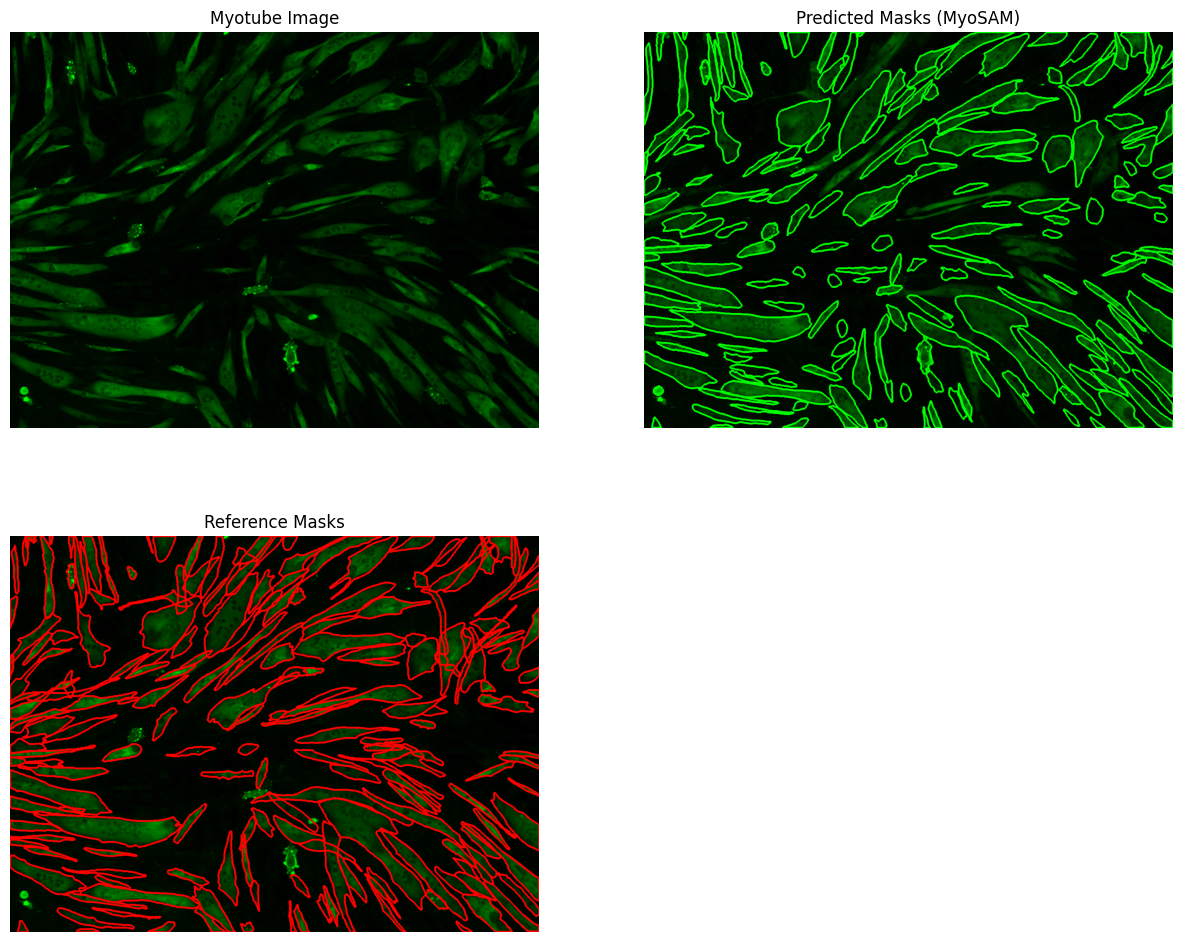

In [26]:
# MyoSAM Performance Visualization
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.imshow(pipeline.myotube_image_np)
plt.title('Myotube Image')
plt.axis('off')

plt.subplot(2, 2, 3)
canvas = pipeline.myotube_image_np.copy()
cv2.drawContours(canvas, myotube_gt_coords, -1, (255, 0, 0), 3)
plt.imshow(canvas)
plt.title('Reference Masks')
plt.axis('off')

plt.subplot(2, 2, 2)
canvas = pipeline.myotube_image_np.copy()
myotube_pred_coords = [myotube.roi_coords_np for myotube in results.information_metrics.myotubes]
cv2.drawContours(canvas, myotube_pred_coords, -1, (0, 255, 0), 3)
plt.imshow(canvas)
plt.title('Predicted Masks (MyoSAM)')
plt.axis('off')

plt.show()

In [ ]:
# StarDist Performance Visualization
plt.figure(figsize=(15, 15))

plt.subplot(3, 2, 1)
plt.imshow(pipeline.nuclei_image_np)
plt.axis('off')
plt.title('Original Image')

plt.subplot(3, 2, 2)
plt.imshow(pipeline.nuclei_image_np[100:500 , 100:500])
plt.axis('off')
plt.title('Image Patch')

plt.subplot(3, 2, 3)
canvas = pipeline.nuclei_image_np.copy()
cv2.drawContours(canvas, nuclei_gt_coords, -1, (255, 0, 0), 1)
plt.imshow(canvas)
plt.axis('off')
plt.title('Reference Masks')

plt.subplot(3, 2, 4)
plt.imshow(canvas[100:500 , 100:500])
plt.axis('off')
plt.title('Reference Masks Patch')

plt.subplot(3, 2, 5)
canvas = pipeline.nuclei_image_np.copy()
nuclei_pred_coords = [nuclei.roi_coords_np for nuclei in results.information_metrics.nucleis]
cv2.drawContours(canvas, nuclei_pred_coords, -1, (0, 255, 0), 1)
plt.imshow(canvas)
plt.axis('off')
plt.title('Predicted Masks')

plt.subplot(3, 2, 6)
plt.imshow(canvas[100:500 , 100:500])
plt.axis('off')
plt.title('Predicted Masks Patch')

plt.show()